<a href="https://colab.research.google.com/github/lsrodri/KneeOsteoarthritis/blob/main/notebooks/Custom_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning pre-processed data

In [1]:
!git clone https://github.com/lsrodri/KneeOsteoarthritis.git

Cloning into 'KneeOsteoarthritis'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 20 (delta 3), reused 3 (delta 0), pack-reused 7 (from 2)
Receiving objects: 100% (20/20), 46.47 MiB | 15.09 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
import os

if not os.path.exists('data'):
  os.makedirs('data')

!unzip KneeOsteoarthritis/data/processed_data.zip -d data/

Archive:  KneeOsteoarthritis/data/processed_data.zip
   creating: data/processed_data/
   creating: data/processed_data/test/
   creating: data/processed_data/test/1Doubtful/
 extracting: data/processed_data/test/1Doubtful/DoubtfulG1 (248)_1.png  
 extracting: data/processed_data/test/1Doubtful/DoubtfulG1 (116)_1.png  
  inflating: data/processed_data/test/1Doubtful/DoubtfulG1 (287).png  
 extracting: data/processed_data/test/1Doubtful/DoubtfulG1 (146)_1.png  
 extracting: data/processed_data/test/1Doubtful/DoubtfulG1 (124).png  
 extracting: data/processed_data/test/1Doubtful/DoubtfulG1 (45)_1.png  
 extracting: data/processed_data/test/1Doubtful/DoubtfulG1 (115)_1.png  
 extracting: data/processed_data/test/1Doubtful/DoubtfulG1 (16)_1.png  
 extracting: data/processed_data/test/1Doubtful/DoubtfulG1 (368)_1.png  
 extracting: data/processed_data/test/1Doubtful/DoubtfulG1 (261)_1.png  
 extracting: data/processed_data/test/1Doubtful/DoubtfulG1 (419)_1.png  
 extracting: data/processed_

# Import Libraries and Modules

Necessary libraries and modules for building and training a deep learning model using TensorFlow and Keras.

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import (
      BatchNormalization,
      Conv2D,
      Dense,
      Dropout,
      Flatten,
      Lambda,
      MaxPooling2D
)
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Normalization and Optimization

Applying a normalization function to the training and testing datasets using Keras's `Rescaling` layer. This is a common preprocessing step for image data to scale pixel values to a range between 0 and 1, which improves model training with numerically-safe features.

Additionally, the cell caches and prefetches the datasets for performance optimization. Caching keeps the dataset elements in memory after they've been loaded, so they don't need to be reloaded in subsequent epochs. Prefetching overlaps the data preprocessing and model execution, improving training speed.

In [4]:
train_folder = "data/processed_data/train"
test_folder = "data/processed_data/test"

img_height = 224
img_width = 224
batch_size = 32

train = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    verbose=False
)

test = tf.keras.utils.image_dataset_from_directory(
    test_folder,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    verbose=False
)

# Normalization and Dataset Optimization

`normalization` uses Keras'  `Rescaling` layer to scale the pixel values of images to the range \[0, 1]. This normalization step is applied to both the training and testing datasets using the `.map()` function.

Additionally, the datasets are optimized for performance using `.cache()` and `.prefetch(buffer_size=AUTOTUNE)`.
-   `.cache()` keeps the dataset elements in memory after the first epoch, avoiding redundant loading.
-   `.prefetch()` overlaps the data preprocessing and model execution, improving training efficiency by ensuring data is ready when the model needs it.

In [5]:
# Normalization function using Rescaling layer
def normalization(image, label):
  rescale = tf.keras.layers.Rescaling(1./255)
  return rescale(image), label

# Apply normalization to the datasets
train = train.map(normalization)
test = test.map(normalization)

# Cache and prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
HEIGHT = 224
WIDTH = 224
CLASSES = 5

In [7]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 14.0 MB/s eta 0:00:00


# Hyperparameter Tuning with Keras Tuner

Performs Bayesian Optimization to find the best hyperparameters for the CNN model. It defines the model building function and configures the tuner to search for optimal values for filter sizes, dense layer units, dropout rates, optimizer, and learning rate.

In [8]:
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the function to build the model with hyperparameters
def build_cnn_model(hp):
    model = Sequential()

    # Hyperparameters for convolutional layers
    hp_filters_1 = hp.Int('filters_1', min_value=16, max_value=64, step=16)
    hp_filters_2 = hp.Int('filters_2', min_value=32, max_value=128, step=32)
    hp_filters_3 = hp.Int('filters_3', min_value=64, max_value=256, step=64)

    model.add(Conv2D(filters=hp_filters_1, kernel_size=(3, 3), activation='relu', input_shape=(HEIGHT, WIDTH, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=hp_filters_2, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=hp_filters_3, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    hp_units_1 = hp.Int('units_1', min_value=256, max_value=1024, step=256)
    hp_units_2 = hp.Int('units_2', min_value=64, max_value=256, step=64)

    model.add(Dense(units=hp_units_1, activation='relu'))

    hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout_1))

    model.add(Dense(units=hp_units_2, activation='relu'))
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout_2))

    model.add(Dense(units=CLASSES, activation='softmax'))

    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    if hp_optimizer == 'adam':
        optimizer = Adam(learning_rate=hp_learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)


    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = kt.BayesianOptimization(
    build_cnn_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=2,
    directory="knee_osteoarthritis_kt",
    project_name="cnn_tuning",
    overwrite=True,
    max_consecutive_failed_trials=5
)

tuner.search_space_summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

tuner.search(train,
             validation_data=test,
             epochs=10,
             callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of filters in the first conv layer is {best_hps.get('filters_1')}.
The optimal number of filters in the second conv layer is {best_hps.get('filters_2')}.
The optimal number of filters in the third conv layer is {best_hps.get('filters_3')}.
The optimal number of units in the first dense layer is {best_hps.get('units_1')}.
The optimal number of units in the second dense layer is {best_hps.get('units_2')}.
The optimal dropout rate for the first dense layer is {best_hps.get('dropout_1')}.
The optimal dropout rate for the second dense layer is {best_hps.get('dropout_2')}.
The optimal optimizer is {best_hps.get('optimizer')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")

best_model = tuner.get_best_models(num_models=1)[0]

loss, accuracy = best_model.evaluate(test)
print(f"Best model loss: {loss:.4f}, accuracy: {accuracy:.4f}")

Trial 10 Complete [00h 00m 50s]
val_accuracy: 0.3145896643400192

Best val_accuracy So Far: 0.44224923849105835
Total elapsed time: 00h 25m 14s

The optimal number of filters in the first conv layer is 32.
The optimal number of filters in the second conv layer is 96.
The optimal number of filters in the third conv layer is 64.
The optimal number of units in the first dense layer is 768.
The optimal number of units in the second dense layer is 192.
The optimal dropout rate for the first dense layer is 0.30000000000000004.
The optimal dropout rate for the second dense layer is 0.1.
The optimal optimizer is adam.
The optimal learning rate is 0.0001.



/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.4900 - loss: 1.2355
Best model loss: 1.3779, accuracy: 0.4468


# Clearing memory before creating optimized model

In [20]:
import gc
from tensorflow.keras import backend as K

# Clear Keras session
K.clear_session()

# Force garbage collection
gc.collect()

# Check if model exists
if 'model' in locals():
    del model
elif 'model' in globals():
  del model


# Model with optimal hyperparameters

Creating the model with hyperparameters optimized with  Bayesian Optimization output



In [9]:
# Check if the Bayesian Optimizer was run. Else, output previous values found to be best
best_hps_available = 'best_hps' in locals() and best_hps is not None

optimal_filters_1 = best_hps.get('filters_1') if best_hps_available else 32
optimal_filters_2 = best_hps.get('filters_2') if best_hps_available else 96
optimal_filters_3 = best_hps.get('filters_3') if best_hps_available else 64
optimal_units_1 = best_hps.get('units_1') if best_hps_available else 768
optimal_units_2 = best_hps.get('units_2') if best_hps_available else 192
optimal_dropout_1 = best_hps.get('dropout_1') if best_hps_available else 0.3
optimal_dropout_2 = best_hps.get('dropout_2') if best_hps_available else 0.1
optimal_optimizer = best_hps.get('optimizer') if best_hps_available else 'adam'
optimal_learning_rate = best_hps.get('learning_rate') if best_hps_available else 0.0001

model = Sequential([
    Conv2D(filters=optimal_filters_1, kernel_size=(3, 3), activation='relu', input_shape=(HEIGHT, WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=optimal_filters_2, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=optimal_filters_3, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=optimal_units_1, activation='relu'),
    Dropout(optimal_dropout_1),
    Dense(units=optimal_units_2, activation='relu'),
    Dropout(optimal_dropout_2),
    Dense(units=CLASSES, activation='softmax')
])

optimal_learning_rate = optimal_learning_rate

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

optimizer = Adam(learning_rate=optimal_learning_rate)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 96)   │        27,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 768)            │    33,227,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 192)            │       147,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,460,133 (127.64 MB)

 Trainable params: 33,460,133 (127.64 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

Trains the CNN model using the prepared training data. It specifies the validation data for monitoring performance during training, sets the number of epochs and batch size, and includes the early stopping callback to prevent overfitting.

In [10]:
history = model.fit(
    train,
    validation_data=test,
    epochs = 30,
    batch_size = 8,
    callbacks = early_stopping,
    verbose = 1
)

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 400ms/step - accuracy: 0.2862 - loss: 1.6222 - val_accuracy: 0.3100 - val_loss: 1.5291
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.3041 - loss: 1.5131 - val_accuracy: 0.3100 - val_loss: 1.5184
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.3478 - loss: 1.4987 - val_accuracy: 0.3343 - val_loss: 1.4888
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.3594 - loss: 1.4746 - val_accuracy: 0.3860 - val_loss: 1.4594
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.3900 - loss: 1.4180 - val_accuracy: 0.3951 - val_loss: 1.4358
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.4270 - loss: 1.3577 - val_accuracy: 0.4134 - val_loss: 1.4151
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.4419 - loss: 1.2969 - val_accuracy: 0.4347 - val_loss: 1.3626
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.5162 - loss: 1.1644 - val_accuracy: 0.4650 -

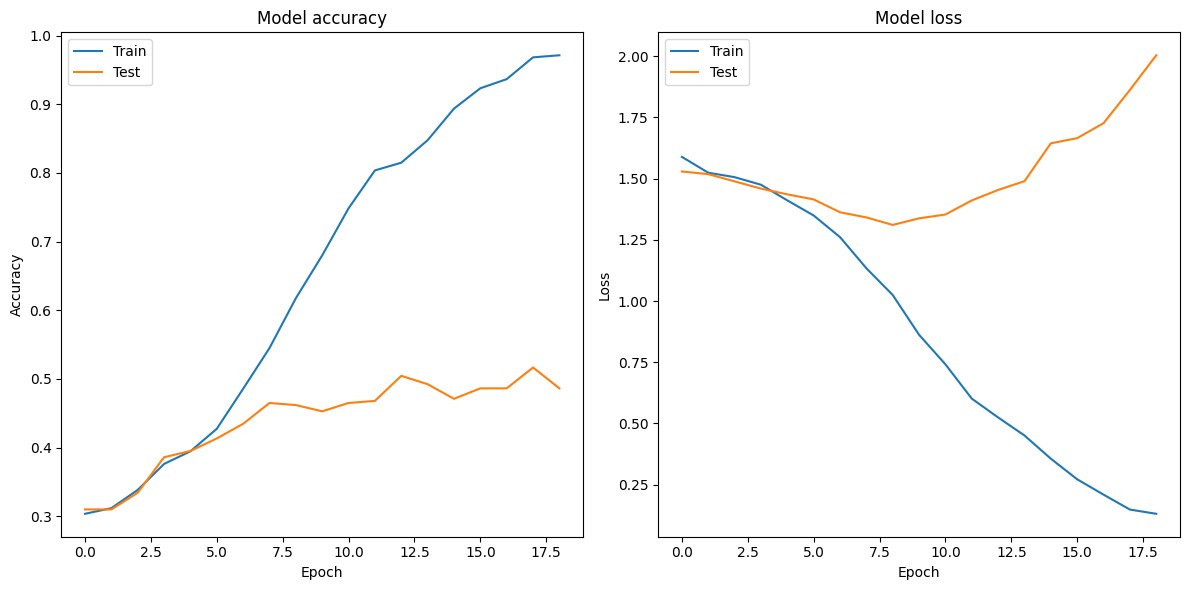

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()